# Trying a tokenized autoencoder

E.g. from IRIS https://github.dev/eloialonso/iris where sparsity is enforced by the tokenization/embedding quantisation bottleneck

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset
# from safetensors.torch import save_file, safe_open
import safetensors.torch

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns

sns.set_theme("paper")

plt.rcParams["figure.figsize"] = (4, 3)

In [2]:
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings(
    "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
)
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")

In [3]:
os.environ["TQDM_MININTERVAL"] = "9"
# os.environ["TQDM_DISABLE"] = "1"

verbose = False

## Paramsnet


In [4]:
# params
# params
batch_size = 32
lr = 4e-3
wd = 0  # 1e-5

MAX_ROWS = 2000

SKIP = 15  # skip initial N layers
STRIDE = 4  # skip every N layers
DECIMATE = 1  # discard N features for speed

device = "cuda:0"
max_epochs = 84

l1_coeff = 1e-2  # 0.5  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
# x_feats=x_feats. other use 1e-1
# in ai saftey foundation. They use l1_coefficient=Parameter(max=0.03, min=0.008),


BASE_FOLDER = Path(
    "/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/"
)
layers_names = ("fc1", "Wqkv",
                #  "fc2", "out_proj"
                 )

## Load data

In [5]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob("hidden_states/.ds/ds_valtest_*")))
f1_ood = next(iter(BASE_FOLDER.glob("hidden_states/.ds/ds_OOD_*")))
f1_val, f1_ood

(PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_valtest_8b8fd6070504d5ef'),
 PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_OOD_a41d3a61513ade30'))

In [6]:
input_columns = (
    ["binary_ans_base", "binary_ans_adapt"]
    + [f"end_residual_{layer}_base" for layer in layers_names]
    + [f"end_residual_{layer}_adapt" for layer in layers_names]
)

y_thresh = 0.5
def get_label(ds):
    # What are we predicting? Here it's whether the adapter is more truthfull than the base
    # return ds["binary_ans_base"] - ds["binary_ans_adapt"]

    # if base is truthfull. relative token prob, flipped for truth
    return ds["binary_ans_base"]


def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f"end_residual_{layer}_base"], ds[f"end_residual_{layer}_adapt"]]
        X1 = rearrange(X1, "versions b l f  -> b l f versions")[..., 0]
        data.append(X1)

    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    
    y = get_label(ds)
    return dict(X=X, y=y)


def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y

    """
    ds = (
        ds.with_format("torch")
        .select_columns(input_columns)
        .map(ds2xy_batched, batched=True, batch_size=128, remove_columns=input_columns)
    )
    return ds


def load_file_to_dm(f, stage):
    ds1 = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds1 = filter_ds_to_known(ds1, verbose=True, true_col="truth")
    ds = prepare_ds(ds1)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS * 2)
    ds = ds.select(range(0, MAX_SAMPLES))
    ds1 = ds1.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=0)
    dm.setup(stage)
    dm.ds_orig = ds1
    assert (get_label(dm.ds_orig)==dm.ds['y']).all()
    return dm


# HACK this is so we can rerun all cells notebook without rerunning this slow step
try:
    print(dm)
except NameError:
    dm = load_file_to_dm(f1_val, "train")
    dm_ood = load_file_to_dm(f1_ood, "all")

select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-20 10:49:34.419 | INFO     | src.datasets.act_dm:setup:68 - converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train
2024-01-20T10:49:34.419858+0800 INFO converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train


setup train
select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-20 10:50:17.298 | INFO     | src.datasets.act_dm:setup:68 - converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all
2024-01-20T10:50:17.298486+0800 INFO converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all


setup all


In [7]:
dm_ood.datasets

{'all': <torch.utils.data.dataset.TensorDataset at 0x7fde198aa310>}

In [8]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])
keeping top 4.22% of features


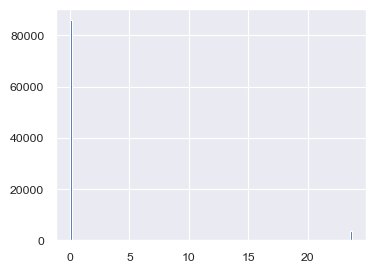

In [9]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[
    SKIP::STRIDE, ::DECIMATE
]


# importance_matrix = importance_matrix ** 3 # square to make it positive
importance_matrix = (importance_matrix - 1).abs() ** 2


# importance_matrix = importance_matrix / (0.1*importance_matrix.std())
# importance_matrix = importance_matrix + 1

# square to make it positive
# importance_matrix = importance_matrix.clamp(0, None)
# importance_matrix -= importance_matrix.mean() - 1

s = importance_matrix.std()
importance_matrix = (importance_matrix > s * 3) * 1.0
print(f"keeping top {importance_matrix.mean():2.2%} of features")
importance_matrix = importance_matrix / importance_matrix.mean()

plt.hist(importance_matrix.flatten(), bins=155)

importance_matrix.mean()

importance_matrix = None

In [10]:
# ((importance_matrix>0)*1.0).sum()

In [11]:
# ds_test2 = dm.datasets['test']
# shape1 = ds_test2[0][0].shape
# shape2= importance_matrix.shape
# np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


### helpers

In [12]:
from src.eval.ds import ds2df
from src.helpers.pandas_classification_report import classification_report, confusion_matrix



def get_acc_subset(df, query, verbose=True):
    # assert (df["y"].mean() < 0).any(), "y should be [-1, 1]"
    assert (df["y"].min() >= 0).all(), "y should be [-1, 1]"
    assert (df["y"].max() <= 1).all(), "y should be [-1, 1]"
    assert (df["probe_pred"].min() >= 0).all(), "pred should be [0,1]"
    assert (df["probe_pred"].max() <= 1).all(), "pred should be [0,1]"

    if query:
        df = df.query(query)
    acc = ((df["probe_pred"] > 0.5) == (df["y"] > y_thresh)).mean()
    # print(df['probe_pred'])
    # print(df['y'])
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, net, trainer=None, split="test", verbose=True):
    # predict
    dl = dm.create_dataloader(split)
    if trainer is None:
        trainer = pl.Trainer(
            logger=False, enable_progress_bar=False, enable_model_summary=False, barebones=True,
        )
    rt = trainer.predict(net, dataloaders=dl)
    y_test_pred = np.concatenate(rt)

    # get original df
    splits = dm.splits[split]
    df = ds2df(dm.ds_orig).rename(columns=lambda s: s.replace("_base", ""))
    df["y"] = dm.ds["y"]
    df["label_true"]
    df_test = df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred
    
    if verbose:
        target_names = ['true','lie']
        df_cls = classification_report(df_test["y"]>y_thresh, df_test["probe_pred"] > 0.5, target_names=target_names)
        display(df_cls.format(precision=2))
        display(confusion_matrix(df_test["y"]>y_thresh, df_test["probe_pred"] > 0.5, target_names=target_names, normalize='all',).format(precision=2))

    if verbose:
        print(f"probe results on subsets of the data for {split}")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=False
    )

    df_quad = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    df_quad.index.name = "instructed to"
    df_quad.columns.name = "llm gave"

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe on {split}")
        print(
            f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe on {split}"
        )

    print("\n\nprobe accuracy for quadrants (doesn't need to add up):")
    print(df_quad.round(2).to_markdown())
    print("\n\n")

    return dict(
        acc=acc,
        acc_lie_lie=acc_lie_lie,
        acc_lie_truth=acc_lie_truth,
        df_test=df_test,
        df_confusion=df_quad,
    )


# r = testval_metrics = calc_metrics(dm, net)
# r['df_test']

In [13]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):
    # plot image of latent space 
    vmax = latent.abs().max()
    for i in range(4): # first 4 batches
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.title(f"batch {i}")
        plt.ylabel("layer")
        plt.xlabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b l n -> (b n) l").T#.flatten()
    print(latentf.shape)
    for i in range(latent.shape[1]):
        plt.hist(latentf[i], bins=25,
                histtype="step", log=True, label=f"layer {i}", density=True)
    plt.title("latents by layer")
    plt.xlabel('latent magnitude')
    plt.legend()
    plt.show()

# plot_latent(latent)

In [54]:

def partial_load_from_pl_checkpoint(net, f, allowed_prefixes = ['ae.', 'norm.']):
    sd = torch.load(open(f, 'rb'))['state_dict']
    
    sd2 = {k: v for k, v in sd.items() if any(k.startswith(p) for p in allowed_prefixes)}
    print(net.load_state_dict(sd2, strict=False))
    
# partial_load_from_pl_checkpoint(net2, LOAD_CHECKPONT)

In [14]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results

# Model

In [15]:
from src.vae.tae import PL_TAE

# Train

### Setup

In [82]:
print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b  # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]

10 5
torch.Size([32, 5, 17920]) x


In [83]:
net = PL_TAE(
    c_in=c_in,
    steps_per_epoch=len(dl_train),
    max_epochs=max_epochs,
    lr=lr,
    dropout=0.2,
    encoder_sizes=[64,64, 64, 64],
    weight_decay=wd,
    n_latent=512,  # there will be layers * n_latent latent features
    importance_matrix=importance_matrix,
    tokens_per_layer=6,
    probe_embedd_dim=512,
)
print(net)

PL_TAE(
  (norm): Affines(
    (affines): ModuleList(
      (0-4): 5 x AffineInstanceNorm1d(17920, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (ae): Tokenizer(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): NormedLinears(
          (linears): ModuleList(
            (0-4): 5 x NormedLinear(in_features=17920, out_features=64, bias=False)
          )
          (act): ReLU()
        )
        (1): NormedLinears(
          (linears): ModuleList(
            (0-4): 5 x NormedLinear(in_features=64, out_features=64, bias=False)
          )
          (act): ReLU()
        )
        (2): NormedLinears(
          (linears): ModuleList(
            (0-4): 5 x NormedLinear(in_features=64, out_features=64, bias=True)
          )
          (act): ReLU()
        )
        (3): NormedLinears(
          (linears): ModuleList(
            (0-4): 5 x NormedLinear(in_features=64, out_features=64, bias=True)
          )
          (act): ReLU()
        )
 

In [84]:
print(c_in)
x1 = x[..., 0]
with torch.no_grad():
    y = net(x1)
# {k: v.abs().mean() for k, v in y.items()}, {k: v.shape for k, v in y.items()}
# y

torch.Size([5, 17920])


In [85]:
from torchinfo import summary

summary(net, input_data=x1, depth=4, col_names=("input_size", "output_size", "num_params",))  # input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
PL_TAE                                             [32, 5, 17920]            --                        --
├─Affines: 1-1                                     [32, 5, 17920]            [32, 5, 17920]            --
│    └─ModuleList: 2-1                             --                        --                        --
│    │    └─AffineInstanceNorm1d: 3-1              [32, 17920]               [32, 17920]               --
│    │    └─AffineInstanceNorm1d: 3-2              [32, 17920]               [32, 17920]               --
│    │    └─AffineInstanceNorm1d: 3-3              [32, 17920]               [32, 17920]               --
│    │    └─AffineInstanceNorm1d: 3-4              [32, 17920]               [32, 17920]               --
│    │    └─AffineInstanceNorm1d: 3-5              [32, 17920]               [32, 17920]               --
├─Tokenizer: 1-2                         

### Train autoencoder

In [86]:
torch.set_float32_matmul_precision("medium")

In [87]:
# with torch.no_grad():
#     o = net.predict_step(b)
#     l1_loss, l2_loss, loss, acts, h_reconstructed = net.ae(b[0])
#     # l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

In [88]:
net.ae_mode(0)
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs,  # * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
    # enable_model_summary=verbose,
)

LOAD_CHECKPONT='/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_377/checkpoints/epoch=83-step=840.ckpt'
LOAD_AE_SAFETENSORS = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_377/ae.safetensors'

# LOAD_CHECKPONT = None
# LOAD_AE_SAFETENSORS = None # good for when probe changed but no ae
if LOAD_AE_SAFETENSORS is not None:
    print(f"loading ae from {LOAD_AE_SAFETENSORS}")
    # net.ae.load_state_dict(safetensors.torch.load_file(LOAD_AE_SAFETENSORS))
    partial_load_from_pl_checkpoint(net, LOAD_CHECKPONT)
elif LOAD_CHECKPONT:
    print(f"loading from {LOAD_CHECKPONT}")
    net = PL_TAE.load_from_checkpoint(LOAD_CHECKPONT)

else:
    trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
    df_hist, df_hist_step = read_metrics_csv(
        trainer1.logger.experiment.metrics_file_path
    )
    plot_hist(df_hist, ["reconstruction_loss", "commitment_loss", "loss_rec"], logy=True)
    # plt.show()
    # plot_hist(df_hist_step, ['loss_rec_step'], logy=True)
    display(df_hist)
    df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

training ae
requires_grad: True
loading ae from /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_377/ae.safetensors
_IncompatibleKeys(missing_keys=['head.0.weight', 'head.2.lin.weight', 'head.2.lin.bias', 'head.2.bn.weight', 'head.2.bn.bias', 'head.2.bn.running_mean', 'head.2.bn.running_var', 'head.3.lin.weight', 'head.3.lin.bias', 'head.4.weight', 'head.4.bias'], unexpected_keys=[])


In [89]:
# plot_hist(df_hist, ["reconstruction_loss", "commitment_loss", "loss_rec"], logy=True)

In [90]:
# note, loss, should be <1
rs3r = trainer1.test(
    net, dataloaders=[dl_train, dl_val, dl, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


|                     |   train |     val |    test |     ood |
|:--------------------|--------:|--------:|--------:|--------:|
| loss_rec_epoch      |   0.487 |   0.56  |   0.543 |   0.52  |
| commitment_loss     |   0.008 |   0.007 |   0.007 |   0.008 |
| reconstruction_loss |   0.479 |   0.553 |   0.536 |   0.512 |
| n                   | 307     | 154     | 154     | 615     |


In [91]:
best_model_path = trainer1.checkpoint_callback.best_model_path
print(f"LOAD_CHECKPONT='{best_model_path}'")

f = trainer1.log_dir + "/ae.safetensors"
safetensors.torch.save_file(net.ae.state_dict(), f)
print(f"LOAD_AE_SAFETENSORS = '{f}'")

LOAD_CHECKPONT=''
LOAD_AE_SAFETENSORS = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_387/ae.safetensors'


In [92]:
# # QC: check loading
# net2 = PL_TAE(
#     c_in=c_in,
#     steps_per_epoch=len(dl_train),
#     max_epochs=max_epochs,
#     lr=lr,
#     dropout=0.2,
#     encoder_sizes=[64,64, 64, 64],
#     weight_decay=wd,
#     n_latent=512,  # there will be layers * n_latent latent features
#     importance_matrix=importance_matrix,
#     tokens_per_layer=6,
#     probe_embedd_dim=512,
# )
# net2.ae_mode(0)
# partial_load_from_pl_checkpoint(net2, LOAD_CHECKPONT)

# # note, loss, should be <1
# rs3r = trainer1.test(
#     net2, dataloaders=[dl_train, dl_val, dl, dl_ood], verbose=False
# )
# rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

#### QC

In [93]:
x1 = x[..., 0]
with torch.no_grad():
    y = net(x1)

print('QC: view latent')


QC: view latent


z before quant


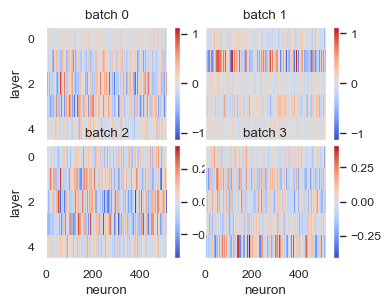

torch.Size([5, 16384])


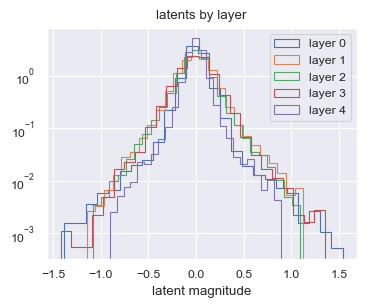

In [94]:
print('z before quant')
plot_latent(y['z'][..., 0]) 


z after quant


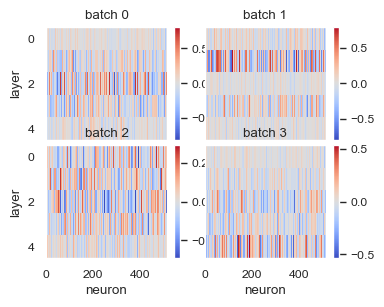

torch.Size([5, 16384])


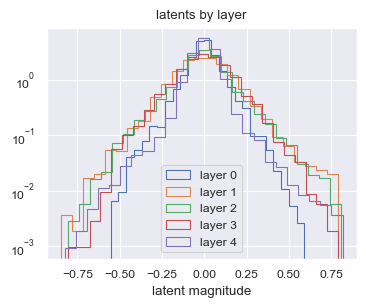

In [95]:
print('z after quant')
plot_latent(y['z_q'][..., 0]) 


In [103]:

y.keys()
# y['z_q'].shape, y['tokens'].shape

(torch.Size([32, 5, 512, 6]), torch.Size([32, 5, 6]))

In [97]:
# print('z_q after embed(z.argmin())')
# latent = y["latent_probe"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
# plot_latent(latent[..., 0])

In [98]:
# sparsity = ((latent!=0) * 1.0).mean()
# print(f'QC: latent usage {sparsity:2.2%}')
# # sparsity_mult = y['l1_losses']/y['l1_raw']
# # print(f'QC: sparsity multiplier per layer {sparsity_mult.mean(0)}')

In [99]:
net.ae_cfg

AutoEncoderConfig(n_instances=5, n_input_ae=17920, n_hidden_ae=3072, l1_coeff=0.5, encoder_sizes=[64, 64, 64, 64])

torch.Size([32, 5, 6])


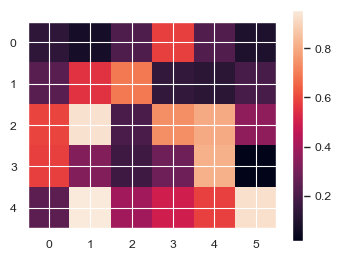

In [100]:
print(y['tokens'].shape)
im = y['tokens']/net.vocab_size
# batch, layers, tokens_per_layer

plt.imshow(im[0])
plt.colorbar()

### Train probe

In [101]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    # precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
    # enable_model_summary=verbose,
    # callbacks=[lr_logger],
)
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);

training probe
requires_grad: False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | norm | Affines    | 0     
1 | ae   | Tokenizer  | 14.1 M
2 | head | Sequential | 472 M 
------------------------------------
472 M     Trainable params
14.1 M    Non-trainable params
486 M     Total params
1,945.321 Total estimated model params size (MB)
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


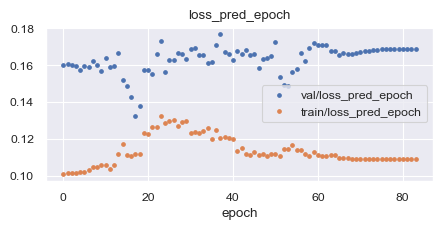

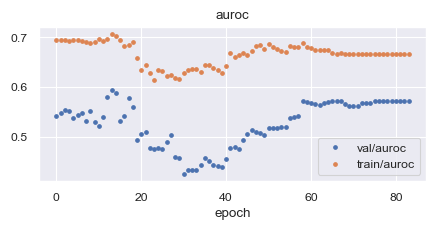

,train/loss_pred_step,step,val/loss_pred_step,val/auroc,val/n,val/acc,val/loss_pred_epoch,train/loss_pred_epoch,train/acc,train/auroc,train/n
epoch,,,,,,,,,,,
0.0,0.072456,9,0.093258,0.541768,154.0,0.454545,0.160168,0.100941,0.713355,0.694614,307.0
1.0,0.072270,19,0.092686,0.546369,154.0,0.461039,0.160450,0.101191,0.716612,0.693648,307.0
2.0,0.071483,29,0.093136,0.553473,154.0,0.461039,0.159954,0.101251,0.713355,0.693297,307.0
3.0,0.074354,39,0.093908,0.551696,154.0,0.467532,0.159517,0.101379,0.713355,0.692913,307.0
4.0,0.072479,49,0.095615,0.536511,154.0,0.461039,0.157647,0.102015,0.716612,0.694347,307.0
...,...,...,...,...,...,...,...,...,...,...,...
79.0,0.081863,799,0.124863,0.571007,154.0,0.487013,0.168676,0.109057,0.684039,0.665969,307.0
80.0,0.081863,809,0.124795,0.571007,154.0,0.487013,0.168674,0.109059,0.684039,0.665969,307.0
81.0,0.081863,819,0.124752,0.571007,154.0,0.487013,0.168681,0.109057,0.684039,0.665969,307.0


In [ ]:
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ["loss_pred_epoch", "auroc"])
df_hist

In [ ]:
rs3r = trainer2.test(
    net, dataloaders=[dl_train, dl_val, dl, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


|                 |   train |     val |    test |     ood |
|:----------------|--------:|--------:|--------:|--------:|
| auroc           |   0.647 |   0.571 |   0.517 |   0.597 |
| acc             |   0.651 |   0.487 |   0.468 |   0.564 |
| loss_pred_epoch |   0.118 |   0.169 |   0.165 |   0.142 |
| n               | 307     | 154     | 154     | 615     |


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
# TODO wrong?
a = calc_metrics(dm, net, split="test", verbose=False)
b = calc_metrics(dm, net, split="val", verbose=False)
c = calc_metrics(dm_ood, net, split="all", verbose=False)
df_metrics = pd.DataFrame([a, b, c], index=["test", "val", "ood"]).iloc[:, :3]
print(df_metrics.round(2).to_markdown())
df_metrics

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]




probe accuracy for quadrants (doesn't need to add up):
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.48 |     0.47 |
| tell a lie      |  0.5  |     0.42 |





LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]




probe accuracy for quadrants (doesn't need to add up):
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.41 |     0.69 |
| tell a lie      |  0.33 |     0.5  |





probe accuracy for quadrants (doesn't need to add up):
| instructed to   |   did |   didn't |
|:----------------|------:|---------:|
| tell a truth    |  0.57 |     0.56 |
| tell a lie      |  0.4  |     0.57 |



|      |   acc |   acc_lie_lie |   acc_lie_truth |
|:-----|------:|--------------:|----------------:|
| test |  0.47 |          0.5  |            0.42 |
| val  |  0.49 |          0.33 |            0.5  |
| ood  |  0.56 |          0.4  |            0.57 |


,acc,acc_lie_lie,acc_lie_truth
test,0.467532,0.500000,0.423077
val,0.487013,0.333333,0.500000
ood,0.564228,0.400000,0.566667


### Train end-to-end


In [ ]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
net.ae_mode(2)
trainer3 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer3.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1

In [ ]:
# ds2df(dm.ds_orig)


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer3.logger.experiment.metrics_file_path)
plot_hist(df_hist, ["loss_pred", "acc"])

rs3r = trainer3.test(
    net, dataloaders=[dl_train, dl_val, dl, dl_ood], verbose=False
)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

# predict
a = calc_metrics(dm, net, trainer1, "test")
b = calc_metrics(dm, net, trainer1, "val")
pd.DataFrame([a, b], index=["test", "val"])

c = calc_metrics(dm_ood, net, trainer1, "all")
pd.DataFrame([a, b, c], index=["test", "val", "ood"])

In [ ]:
a = calc_metrics(dm, net, trainer1, "test")
b = calc_metrics(dm, net, trainer1, "val")
c = calc_metrics(dm_ood, net, trainer1, "all")
df_metrics = pd.DataFrame([a, b, c], index=["test", "val", "ood"]).iloc[:, :3]
print(df_metrics.round(3).to_markdown())
df_metrics